Цель: 

Сравнить эффективность различных онлайн-алгоритмов машинного обучения  при решении задачи распознавания рукописных букв  из датасета EMNIST Letters . 
Задача: 

    Распознавание рукописных латинских букв (A–Z).
    Классификация изображений размером 28×28 пикселей.
    Сравнение алгоритмов при разных пропорциях обучающей и тестовой выборок.
     

Используемые алгоритмы: 

    SGDClassifier — стохастический градиентный спуск
    Perceptron
    PassiveAggressiveClassifier I/II
    LogisticRegression с SAG-оптимизацией
     

Источник данных: 

    Датасет: EMNIST Letters 
    Образцы: 145 600 изображений рукописных букв A–Z
    В работе используется ограниченная подвыборка (~1800 образцов)  для сравнения с digits() из sklearn.
     

Препроцессинг данных

In [1]:
import torch
from torchvision import datasets, transforms
import numpy as np

# Преобразование изображений в одномерные массивы
transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: x.view(-1).numpy()
])

# Загрузка EMNIST
train_dataset = datasets.EMNIST(
    root='./data', split='letters', train=True, download=True, transform=transform
)
test_dataset = datasets.EMNIST(
    root='./data', split='letters', train=False, download=True, transform=transform
)

# Извлечение данных
X_train = [x for x, y in train_dataset]
y_train = [y - 1 for x, y in train_dataset]  # Перенумерация меток: 1..26 → 0..25

X_test = [x for x, y in test_dataset]
y_test = [y - 1 for x, y in test_dataset]

# Объединение выборок
X = np.array(X_train + X_test)
y = np.array(y_train + y_test)

# Ограничение до ~1800 образцов
SAMPLE_LIMIT = 1800
X = X[:SAMPLE_LIMIT]
y = y[:SAMPLE_LIMIT]

print("Форма данных:", X.shape, y.shape)

Форма данных: (1800, 784) (1800,)


Обучение модели

In [2]:
from sklearn.linear_model import (
    LogisticRegression,
    PassiveAggressiveClassifier,
    Perceptron,
    SGDClassifier,
)
from sklearn.model_selection import train_test_split

# Параметры эксперимента
heldout = [0.95, 0.90, 0.75, 0.50, 0.01]  # Доли тестовой выборки
rounds = 10  # Число повторений для усреднения
rng = np.random.RandomState(42)

# Модели
classifiers = [
    ("SGD", SGDClassifier(max_iter=110)),
    ("ASGD", SGDClassifier(max_iter=110, average=True)),
    ("Perceptron", Perceptron(max_iter=110)),
    ("Passive-Aggressive I", PassiveAggressiveClassifier(max_iter=110, loss="hinge", C=1.0, tol=1e-4)),
    ("Passive-Aggressive II", PassiveAggressiveClassifier(max_iter=110, loss="squared_hinge", C=1.0, tol=1e-4)),
    ("SAG", LogisticRegression(max_iter=110, solver="sag", tol=1e-1, C=1.0e4 / X.shape[0])),
]

xx = 1.0 - np.array(heldout)  # Пропорция обучающих данных

# Обучение и оценка моделей
results = {}

for name, clf in classifiers:
    print(f"Обучение: {name}")
    yy = []
    for test_size in heldout:
        errors = []
        for r in range(rounds):
            X_train_part, X_test_part, y_train_part, y_test_part = train_test_split(
                X, y, test_size=test_size, random_state=rng
            )
            clf.fit(X_train_part, y_train_part)
            y_pred = clf.predict(X_test_part)
            error_rate = 1 - np.mean(y_pred == y_test_part)
            errors.append(error_rate)
        yy.append(np.mean(errors))
    results[name] = yy

Обучение: SGD
Обучение: ASGD
Обучение: Perceptron
Обучение: Passive-Aggressive I


/home/max/lab4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Обучение: Passive-Aggressive II


/home/max/lab4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/max/lab4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Обучение: SAG


Визуализация

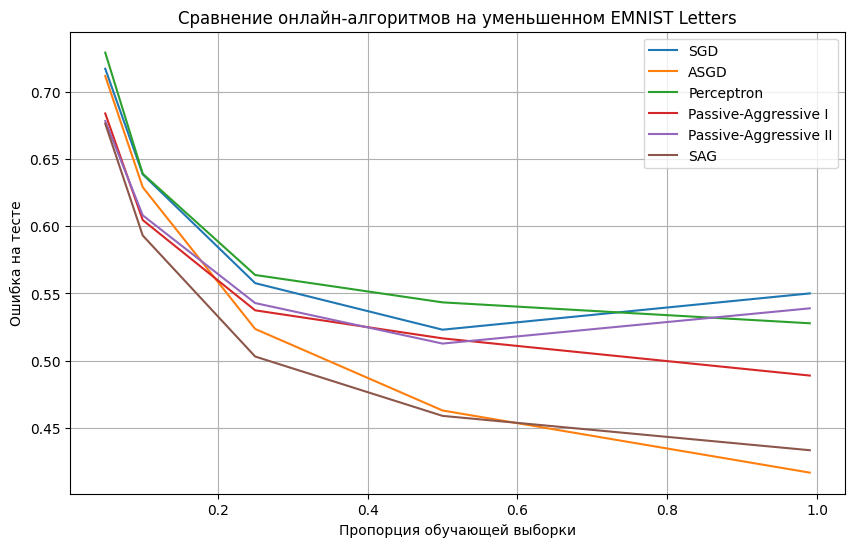

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for name, values in results.items():
    plt.plot(xx, values, label=name)

plt.legend(loc="upper right")
plt.xlabel("Пропорция обучающей выборки")
plt.ylabel("Ошибка на тесте")
plt.title("Сравнение онлайн-алгоритмов на уменьшенном EMNIST Letters")
plt.grid(True)
plt.show()

Интерпретация результатов 

На графике видно, как ошибка классификации  меняется в зависимости от доли обучающих данных , для каждого из используемых алгоритмов. 
Что можно заметить: 

    SGDClassifier  может показывать хорошие результаты при больших наборах данных, но менее стабильный при малых.
    ASGD  (усреднённый SGD) часто более стабилен и быстрее сходится.
    PassiveAggressive I/II  хорошо подходят для потокового обучения и реагируют только на ошибки.
    SAG  (LogisticRegression с SAG) может быть наиболее точным при достаточном объёме данных.
     